In [1]:
import numpy as np
import scipy.linalg as la
import pickle

from scipy.optimize import minimize
from itertools import product

from qiskit import *
from qiskit.quantum_info.states.random import random_density_matrix
from qiskit.quantum_info import Statevector, DensityMatrix, partial_trace

import matplotlib.pyplot as plt
from mpl_axes_aligner import shift
plt.rcParams.update(
    {"text.usetex": True, "font.family": "serif", "font.size": 10}
)

In [2]:
def dictionary_of_actions(num_qubits):
    dictionary = dict()
    i = 0
    for c, x in product(range(num_qubits),
                        range(1, num_qubits)):
        dictionary[i] =  [c, x, num_qubits, 0]
        i += 1
    for r, h in product(range(num_qubits),
                           range(1, 4)):
        dictionary[i] = [num_qubits, 0, r, h]
        i += 1
    return dictionary

def make_circuit_qiskit(action, qubits):
    ctrl = action[0]
    targ = (action[0] + action[1]) % qubits
    rot_qubit = action[2]
    rot_axis = action[3]
#     print(1)
    if ctrl < qubits:
        circuit.cx([ctrl], [targ])
    if rot_qubit < qubits:
        if rot_axis == 1:
            circuit.rx(0, rot_qubit) # TODO: make a function and take angles
        elif rot_axis == 2:
            circuit.ry(0, rot_qubit)
        elif rot_axis == 3:
            circuit.rz(0, rot_qubit)
        else:
            stop
    return circuit

def eigenvals_func(theta, rdm, ansatz):
    """Return the eigenvalues"""
    qc_eigenvals = ansatz
    dm_evo = rdm.evolve(qc_eigenvals)
    dm_evo = dm_evo.data
    diagnls = list((np.diagonal(dm_evo)).real)
    diag_A = []
    diag_A.append(diagnls)
    return diag_A, dm_evo, qc_eigenvals

In [30]:
qubits, rank, seed_agent, seed =3,4,102,100

In [31]:
if qubits == 2:
    data = np.load(f'results/random_search/h_s_{qubits}_rank_{rank}_{seed}/summary_100.npy',allow_pickle=True)[()]
    data_rand = np.load(f'results/random_search/h_s_{qubits}_rank_{rank}_rand_{seed}/summary_100.npy',allow_pickle=True)[()]
    thresh, low_lim = 1e-5, 1e-8
elif qubits == 3:
    data = np.load(f'results/global_COBYLA/h_s_{qubits}_reduce_heisen/summary_{seed_agent}.npy',allow_pickle=True)[()]
    data_rand = np.load(f'results/global_COBYLA/h_s_{qubits}_reduce_heisen_rand/summary_{seed_agent}.npy',allow_pickle=True)[()]
    thresh, low_lim = 1e-4, 1e-5

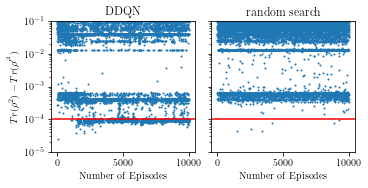

In [32]:
fig, ax = plt.subplots( 1, 2, sharey = True, figsize = (5, 2.5), layout='constrained')
title_text = ['DDQN', 'random search']
for no, d in enumerate([data, data_rand]): 
    data_error_last = [d['train'][ep_no]['errors'][-1] for ep_no in range(10000)]
    ax[no].semilogy(data_error_last, 'o', markersize=1, rasterized=True)
    ax[no].axhline(y=thresh, color='r', linestyle='-')
    ax[no].set_title(title_text[no])
    if no == 0:
        ax[no].set_ylabel('$Tr(\\rho^2) - Tr(\\rho^{\\prime^2})$')
    ax[no].set_xlabel('Number of Episodes')
    ax[no].set_ylim([low_lim, thresh*1000])
# fig.tight_layout()
fig.savefig(f'plot/{qubits}_qubit_rand_search_agent_compare.pdf',dpi=300)
fig.savefig(f'plot/{qubits}_qubit_rand_search_agent_compare.png')
# plt.savefig('rasterized_transparency.eps',)

In [9]:
episodes = 10000
data = data
test_train = 'train'

First successful episode: 0 and error 0.001388, total successful episode: 9871
First successful episode: 0 and error 0.015246, total successful episode: 9998


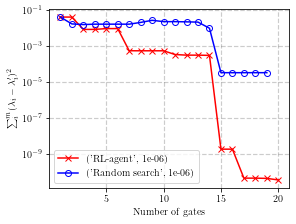

In [16]:
legend_label = ['RL-agent', 'Random search']
line_type = ['r-x', 'b-o']
fig, ax = plt.subplots( 1, 1, sharey=True, figsize = (4, 3), layout='constrained')
for no, d in enumerate([data, data_rand]):
    succ_ep_info_dict = {}
    success_ep, success_ep_error = [], []
    average_err = 0
    for ep_no in range(episodes):
        data_error_last = d[test_train][ep_no]['errors'][-1]
    #     data_error_last -= 6.694750006687696
        if data_error_last >= 1e-6:
            success_ep.append(ep_no)
            success_ep_error.append(data_error_last)
            average_err += data_error_last
    average_err /= len(success_ep)
    print(f'First successful episode: {success_ep[0]} and error {round(success_ep_error[0],6)}, total successful episode: {len(success_ep)}')

    succ_ep_info_dict['succ_ep_list'] = success_ep
    succ_ep_info_dict['succ_ep_err_list'] = success_ep_error
    
    with open(f'plot_data/{qubits}_qubit_mixed_rank_{rank}_seed_{seed_agent}_succ_ep_data.p', 'wb') as fp:
        pickle.dump(succ_ep_info_dict, fp)

    x = [d[test_train][ep_no]['actions'] for ep_no in success_ep]
    circuit_info_dict = {}
    depth_list = []
    oneq_gate_list = []
    twoq_gate_list = []
    gate_num_list = []
    # depth list:
    for succ_ep in success_ep:
        actions = data[test_train][succ_ep]['actions']
        circuit = QuantumCircuit(qubits)
        for a in actions:
            action = dictionary_of_actions(qubits)[a]
    #         print(action)
            final_circuit = make_circuit_qiskit(action, qubits)
    #     print(final_circuit)
        gate_info = final_circuit.count_ops()
        key_list = gate_info.keys()
        one_gate, two_gate = 0,0
        for k in key_list:
            if k == 'cx':
                two_gate += gate_info[k]
            else:
                one_gate += gate_info[k]

        twoq_gate_list.append(two_gate)
        oneq_gate_list.append(one_gate)
        gate_num_list.append(one_gate+two_gate)        
        depth_list.append(final_circuit.depth())

    circuit_info_dict['depth_list'] = depth_list
    circuit_info_dict['oneq_gate_list'] = oneq_gate_list
    circuit_info_dict['twoq_gate_list'] = twoq_gate_list
    circuit_info_dict['gate_num_list'] = gate_num_list

    all_ep = [d[test_train][ep_no]['errors'][-1] for ep_no in range(10000)]
    min_err_ep = all_ep.index(np.min(success_ep_error))
    thetas = d['train'][min_err_ep]['opt_ang']
    thetas = list(thetas[-1])
    final_circuit = QuantumCircuit.from_qasm_str(d['train'][min_err_ep]['save_circ'][-1])
    n_gate = 0
    for k in dict(final_circuit.count_ops()).keys():
        n_gate += dict(final_circuit.count_ops())[k]
    err_list = []
    for cut in range(n_gate):
        if qubits == 2:
            state_to_diag_gen = random_density_matrix(2**qubits, rank=4, seed=seed)
        else:
            state_data = []
            with (open(f"state_data/{qubits}_qubit_reduce_heisen_model_state_data.p", "rb")) as openfile:
                while True:
                    try:
                        state_data.append(pickle.load(openfile))
                    except EOFError:
                        break
            state_to_diag_gen = state_data[0]['state']
        final_circuit = QuantumCircuit.from_qasm_str(d['train'][min_err_ep]['save_circ'][-1])
        final_circuit.data = final_circuit[:cut]
        inf_eig = np.sort(eigenvals_func(thetas, state_to_diag_gen, final_circuit)[0])[0]
        import scipy.linalg as la
        ture_eig = np.sort(la.eig(state_to_diag_gen)[0].real)
        #### ERROR IN EIGENVALUE CALCULATION ####
        err = 0
        for eigno in range(qubits**2-1):
            err += np.abs(inf_eig[eigno] - ture_eig[eigno])**2
        err_list.append(err)
    ax.semilogy(range(1, n_gate+1), err_list, line_type[no], markerfacecolor='none', label = f'{legend_label[no], np.round(np.min(success_ep_error), 6)}')
# plt.title()
ax.set_ylabel('$\sum_i^{m}(\\lambda_i - \\lambda^{\\prime}_i)^2$')
ax.set_xlabel('Number of gates')
ax.grid(color='k', linestyle='--', linewidth=1.2, alpha = 0.2)
ax.legend()
fig.savefig(f'plot/{qubits}_qubits_agent_rand_search_gate_num_with_accuracy.pdf')
fig.savefig(f'plot/{qubits}_qubits_agent_rand_search_gate_num_with_accuracy.png')